In [20]:
# import ROOT
import glob
import numpy as np
import pandas as pd

# standard system modules
import os, sys

# to plot pixelized images
import imageio.v3 as im

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

# import roottotext

# https://www.mathworks.com/help/vision/ug/object-detection-using-deep-learning.html

## Trying to find centroids of groups

In [21]:
import scipy.ndimage as ndi
from skimage.feature import peak_local_max
import matplotlib.colors as colors
def load_data(path):
    runs = sorted(glob.glob(os.path.join(path, '*.txt')))
    datalist = [np.loadtxt(run, unpack = False) for run in runs]
    return datalist

def get_particle_class(label):
    """Gets the class name for a given label.
    
    Arguments:
        label (int): The integer target label.
        
    Returns:
        The name of the class that corresponds to the given label.
    """
    return ['triton','proton','deuteron'][label]


SLABdat = load_data(path = './data/9kG/')
# i = 0
smoothed_data = ndi.gaussian_filter((SLABdat[0][:,0],SLABdat[0][:,1]), sigma=0.1)  # adjust sigma for smoothness

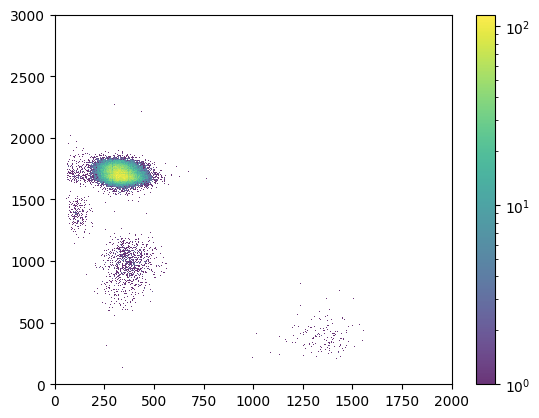

In [22]:
fig, ax = plt.subplots()
hist, xedges, yedges, image = ax.hist2d(smoothed_data[0],smoothed_data[1], bins = [512,512], range = [[0,2000],[0,3000]],cmap = 'viridis', norm = colors.LogNorm(), alpha = 0.8)
plt.colorbar(image, ax = ax)
# plt.scatter(91,1825, facecolor = 'red')
# plt.hist2d(SLABdat[0][:,0],SLABdat[0][:,1], bins = [512,512], range = [[0,2000],[0,3000]],cmap = 'viridis', norm = colors.LogNorm(), alpha = 0.8)
# plt.show()

In [23]:
# np.shape(smoothed_data)

In [42]:
from sklearn.cluster import KMeans
X = "ScintLeft"; Y = "AnodeBack"
SL_min = 0; SL_max = 4000
AB_min = 0 ; AB_max = 4000 

SLAB_full = pd.DataFrame(np.concatenate(SLABdat), columns = [X,Y])
SLAB = SLAB_full[(SLAB_full[X] >= SL_min) & (SLAB_full[X] <= SL_max) & (SLAB_full[Y] >= AB_min) & (SLAB_full[Y] <= AB_max)]
SLAB = SLAB.reset_index(drop=True) # pandas keeps the indices of the original, we want to reset to avoid any future issues

# SLAB = SLAB_full[(SLAB_full[X] >= SL_min) & (SLAB_full[Y] >= AB_min)]


wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=5000, random_state=42)
    kmeans.fit(SLAB)
    wcss.append(kmeans.inertia_)

# Prepare data for visualization:
wcss = pd.DataFrame(wcss, columns = ['num_cluster'])
wcss.index += 1

Text(0, 0.5, 'Within-cluster sum of squares [arb. units]')

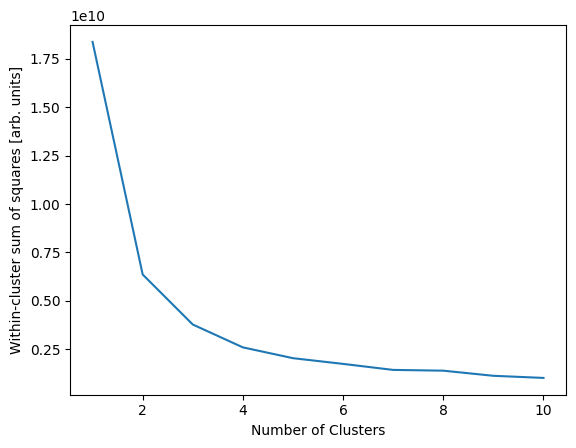

In [43]:
plt.figure()
plt.plot(range(1,11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within-cluster sum of squares [arb. units]')

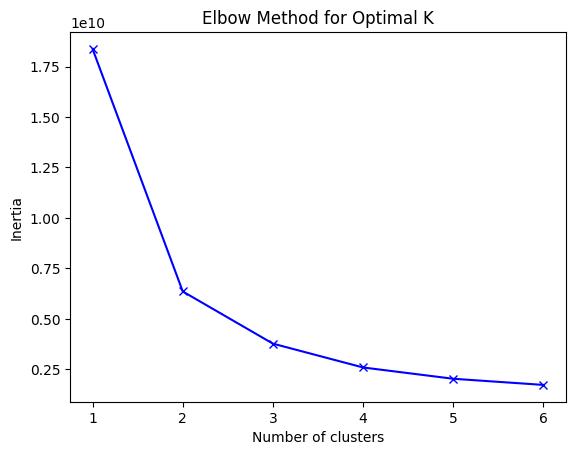

In [44]:
distortions = []
K = range(1, 7)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
    kmeans.fit(SLAB)
    distortions.append(kmeans.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
# Rescales data to better interpret and get better cluster results
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(SLAB[[X, Y]]), columns = [X,Y])
# print(scaled_data[[X, Y]].isna().sum())

In [46]:
# Uses kmeans on scaled_data to get better results
# from sklearn.mixture import GaussianMixture
model = KMeans(n_clusters = 4, n_init = 50, random_state =42, max_iter = 5000)
# model = GaussianMixture(n_components=4)
clusters = model.fit_predict(scaled_data)
# centroids = model.cluster_centers_

labels = pd.DataFrame({'Cluster':clusters}) # defining the cluster labels
labeled = pd.concat((scaled_data,labels),axis = 1)

# Concatenating the labels to the original, unscaled data 
SLAB_label = pd.concat((SLAB,labels), axis = 1)

tritons = SLAB_label[SLAB_label['Cluster'] == 0]
alphas = SLAB_label[SLAB_label['Cluster'] == 3]
protons = SLAB_label[SLAB_label['Cluster'] == 1]
deuterons = SLAB_label[SLAB_label['Cluster'] == 2]


In [32]:
print(scaled_data['ScintLeft'])

0       -0.404198
1        1.221640
2       -0.816382
3        0.408721
4        0.511767
           ...   
67035   -0.587391
67036    0.042335
67037   -0.736235
67038   -0.736235
67039    0.179730
Name: ScintLeft, Length: 67040, dtype: float64


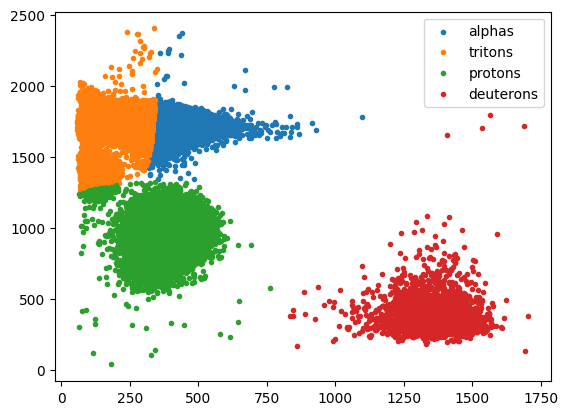

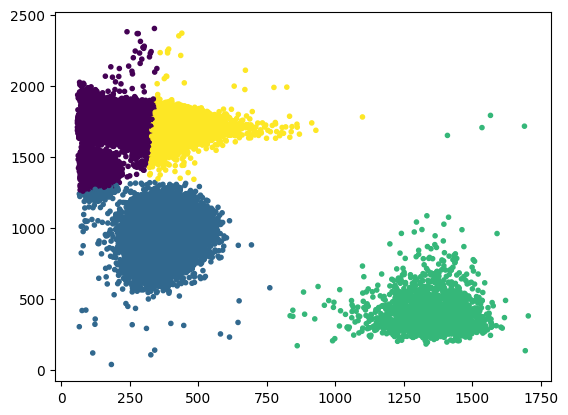

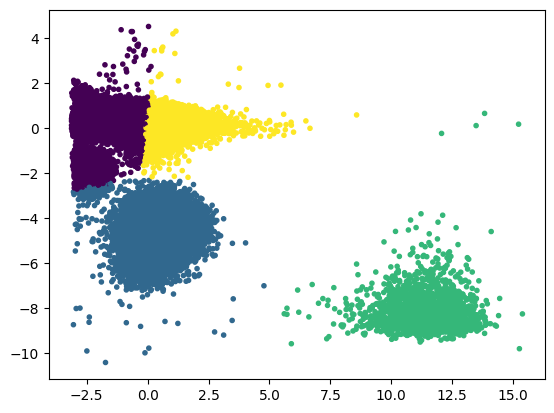

In [47]:

# Plotting results
plt.figure()
# plt.scatter(SLAB[X],SLAB[Y],c = SLAB['Clusters'], marker = '.')
plt.scatter(alphas[X], alphas[Y], marker = '.', label = 'alphas')
plt.scatter(tritons[X],tritons[Y], marker = '.', label = 'tritons')
plt.scatter(protons[X],protons[Y],  marker = '.', label = 'protons')
plt.scatter(deuterons[X],deuterons[Y], marker = '.', label = 'deuterons')
plt.legend( loc = 'best')
# plt.ylim((5,3000))
# plt.xlim((5,2000))

plt.figure()
plt.scatter(SLAB_label[X],SLAB_label[Y],c = SLAB_label['Cluster'], marker = '.')

plt.figure()
plt.scatter(labeled[X], labeled[Y], c = labeled['Cluster'], marker = '.')
# g = SLAB[[X,Y]]
# gx = g[(SLAB['Clusters'] == 2)]; 
# plt.figure()
# plt.scatter(gx[X], gx[Y])

#
#             Need to make filter so that data is within certain range. Outlier data on the fringes is probably what's causing the incorrect 
#             cluster count.
#             https://towardsdatascience.com/k-means-clustering-an-introductory-guide-and-practical-application-dce70bfa4249
#

# plt.figure()
# plt.hist2d(

In [12]:
def euclidean_distance(x, y):
    """
    Computes euclidean distance between two sets of points 
    
    Note: by passing "y=0.0", it will compute the euclidean norm
    
    Args:
        x, y (array<...,n>): float tensors with pairs of 
            n-dimensional points 
            
    Returns:
        A float array of shape <...> with the pairwise distances
        of each x and y point
    """
    return np.linalg.norm(x - y, ord=2, axis=-1)

def cross_euclidean_distance(x, y=None):
    """
    Compute Euclidean distance between two sets of points 
    
    Args:
        x (array<m,d>): float tensor with pairs of 
            n-dimensional points. 
        y (array<n,d>): float tensor with pairs of 
            n-dimensional points. Uses y=x if y is not given.
            
    Returns:
        A float array of shape <m,n> with the euclidean distances
        from all the points in x to all the points in y
    """
    y = x if y is None else y 
    assert len(x.shape) >= 2
    assert len(y.shape) >= 2
    return euclidean_distance(x[..., :, None, :], y[..., None, :, :])

In [14]:
# Rescales data to better interpret and get better cluster results
X = "ScintLeft"; Y = "AnodeBack"
SL_min = 0; SL_max = 4000
AB_min = 0 ; AB_max = 4000 

SLAB_full = pd.DataFrame(SLABdat[0], columns = [X,Y])
SLAB = SLAB_full[(SLAB_full[X] >= SL_min) & (SLAB_full[X] <= SL_max) & (SLAB_full[Y] >= AB_min) & (SLAB_full[Y] <= AB_max)]
SLAB = SLAB.reset_index(drop=True) # pandas keeps the indices of the original, we want to reset to avoid any future issues

scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(SLAB[[X, Y]]), columns = [X,Y])
# print(scaled_data[[X, Y]].isna().sum())


# Fit Model 
model_2 = KMeans(n_clusters = 4, max_iter = 1000)  
model_2.fit(scaled_data)

cross_dist = cross_euclidean_distance(scaled_data.to_numpy(), model_2.cluster_centers_)
cluster_ind = np.argmin(cross_dist, axis = 1)
    
iterations = 5

X = scaled_data
worst_prec = 0.05
n_worst = int(round(X.shape[0]*worst_prec))
best_reroll_centroids = self.centroids
best_reroll_distortion = euclidean_distortion(X, cluster_ind)

for i in range(iterations):
    # Caculate new centroids
    for i in range(model_2.n_clusters):
        X_i = X[cluster_ind == i]
        model_2.cluster_centers_[i] = X_i.mean(axis = 0).to_numpy()
    
    # Find the two centroids that are closest and pick the centoid with the lowest average distance to other centroids
    centroid_dist = cross_euclidean_distance(model_2.cluster_centers_)
    cetorid_dist_inf = centroid_dist + np.diag(np.repeat(np.inf, centroid_dist.shape[0])) # Add inf to diag
    worst_pair = np.unravel_index((cetorid_dist_inf).argmin(), cetorid_dist_inf.shape) # Find indexes of worst pair
    worst_ind = worst_pair[0] if (np.mean(centroid_dist[worst_pair[0]])<np.mean(centroid_dist[worst_pair[1]])) else worst_pair[1]
    
    # Assign the old centroid to be the one closest to the poinst that are furthest away from the current centroids
    min_dists = np.min(cross_dist, axis = 1)
    high_dists_ind = np.argpartition(min_dists, -n_worst)[-n_worst:]
    X_high = X.loc[high_dists_ind]
    self.centroids[worst_ind] = X_high.mean(axis = 0).to_numpy()
    
    # Itterate until convergence
    for _ in range(model_2.max_iter):
        #Calculating new centroids
        for i in range(model_2.m_clusters):
            X_i = X[cluster_ind == i]
            self.centroids[i] = X_i.mean(axis = 0).to_numpy()
        
        #Assigne data points to new cluster and check if cluster assignment chenges
        cross_dist = cross_euclidean_distance(X.to_numpy(), model_2.cluster_centers_)
        cluster_ind_new = np.argmin(cross_dist, axis = 1)
        if not (cluster_ind_new == cluster_ind).any():
            break
        cluster_ind = cluster_ind_new

# Plot cluster assignments
C = model_2.get_centroids()
K = len(C)
_, ax = plt.subplots(figsize=(5, 5), dpi=100)
sns.scatterplot(x='x0', y='x1', hue=z, hue_order=range(K), palette='tab10', data=scaled_data, ax=ax);
sns.scatterplot(x=C[:,0], y=C[:,1], hue=range(K), palette='tab10', marker='*', s=250, edgecolor='black', ax=ax)
ax.legend().remove();

NameError: name 'self' is not defined

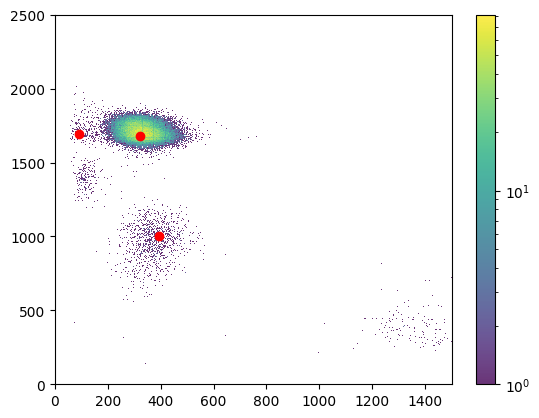

In [103]:
# Find peaks in smoothed data 

# print(x_peak_positions,y_peak_positions)
fig, ax = plt.subplots()
hist, xedges, yedges, image = ax.hist2d(smoothed_data[0],smoothed_data[1], bins = [512,512], range = [[0,1500],[0,2500]],cmap = 'viridis', norm = colors.LogNorm(), alpha = 0.8)
plt.colorbar(image, ax = ax)

peaks = peak_local_max(hist, threshold_abs = 2, num_peaks = 3,min_distance= 20)
x_peak_positions = xedges[peaks[:, 0]] + (xedges[1] - xedges[0]) / 2
y_peak_positions = yedges[peaks[:, 1]] + (yedges[1] - yedges[0]) / 2

peak_pos = np.column_stack((x_peak_positions,y_peak_positions))
plt.scatter(peak_pos[:,0],peak_pos[:,1], facecolor = 'red')

# Preparing training and validation datasets
1. Load datasets from each run.
2. Convert data to PyTorch tensors and split into training, testing, and validation sets.
3. Change shape of tensors from (N,H,W,C) to (N,C,H,W).
4. Move them to computational device.



In [ ]:
def load_data(path):
    runs = sorted(glob.glob(os.path.join(path, '*.txt')))
    datalist = [np.loadtxt(run, unpack = False) for run in runs]
    return datalist

def get_particle_class(label):
    """Gets the class name for a given label.
    
    Arguments:
        label (int): The integer target label.
        
    Returns:
        The name of the class that corresponds to the given label.
    """
    return ['deuteron','triton','alpha'][label]


SLABlist = load_data(path = './SLABtxt/7.3kG/')

## Determining Number of Clusters

In [ ]:
cluster_range = range(2,5)

fig, ax = plt.subplots(len(cluster_range),2)
for n_clusters in cluster_range:


    ax.set_ylim([0, len(scaled_data) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters = n_clusters, random_state = 10)
    cluster_labels = clusterer.fit_predict(scaled_data)
    print(len(cluster_labels))

    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    print("For n_clusters = ", n_clusters , "The average silhouette score is:", silhouette_avg)

    sample_silhouette_values = silhouette_samples(scaled_data,cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        sil_vals = sample_silhouette_values[cluster_labels == i]
        sil_vals.sort()
        size_cluster_i = sil_vals.shape[0]
        
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower,y_upper),
            0,
            sil_vals,
            facecolor = color,
            edgecolor = color,
            alpha = 0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        scaled_data[X], scaled_data[Y], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
plt.show()
        